<a href="https://colab.research.google.com/github/georgeo30/AVL-VS-BST/blob/master/CustomClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mounting from google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#Dataset class that will be used to get an image and its label at a time using the gpu to save memory
#imports for this class
from torch.utils import data
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

class Dataset(data.Dataset):
    #constructor
    def __init__(self, list_IDs, labels, image_transform = None ):
        self.labels = labels
        self.list_IDs = list_IDs
        self.image_transform = image_transform

    #denotes the total number of samples    
    def __len__(self):
        return len(self.list_IDs)

    #generates one sample of the data while performing the transforms required
    def __getitem__(self, index):
        ID = self.list_IDs[index]
        X, y = self.__data_generation(ID)

        return X, y
    #method used to perform the transforms on the image
    def __data_generation(self, ID): 
    
        # Read images using scikit-image io library
        #check if img is from superimposed or natural images
        belong_to_folder=ID[:4]
        if (belong_to_folder=="clss"):
          X = io.imread('gdrive/My Drive/VASTECH-SSSD/SuperImposedClassification/'+ID)
        else:
          X = io.imread('gdrive/My Drive/VASTECH-SSSD/NaturalImgs/'+ID)
        
        # Store class label
        returned_labels = int(self.labels[ID])
       
        X = np.repeat(X[:, :, np.newaxis], 3, axis=2)
        X = Image.fromarray(X, mode = 'RGB') 
        

        if self.image_transform is not None:
            # Transform works on PIL images and should return PyTorch tensor
            X = self.image_transform(X)
        return X, returned_labels

In [ ]:
#imports for training
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [ ]:
# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print(use_cuda)

True


In [ ]:
#using a sampler to get the training,test and validation folder
import os
import random
partition={"train":[],"valid":[],"test":[]}
classes=('Scanned', 'Natural')
allImgs=[]
labels={}
i=0
ntrlImgs=os.listdir('gdrive/My Drive/VASTECH-SSSD/NaturalImgs')
clssImgs=os.listdir('gdrive/My Drive/VASTECH-SSSD/SuperImposedClassification')
for i in range(len(ntrlImgs)-1):
  allImgs.append(ntrlImgs[i])
  labels[ntrlImgs[i]]=1
  allImgs.append(clssImgs[i])
  labels[clssImgs[i]]=0

random.shuffle(allImgs)
partition["train"]=allImgs[:4150]
partition["valid"]=allImgs[4150:4669]
partition["test"]=allImgs[4699:5188]
print(partition)
print(labels)
  

{'train': ['ntrl220.jpg', 'ntrl1239.jpg', 'clss1503.png', 'clss2407.png', 'clss413.png', 'ntrl845.jpg', 'ntrl2547.jpg', 'ntrl595.jpg', 'clss203.png', 'ntrl1401.jpg', 'clss2184.png', 'ntrl1893.jpg', 'clss1505.png', 'ntrl232.jpg', 'ntrl749.jpg', 'ntrl1625.jpg', 'clss924.png', 'clss788.png', 'ntrl2339.jpg', 'ntrl1875.jpg', 'clss507.png', 'clss537.png', 'ntrl10.jpg', 'ntrl887.jpg', 'ntrl2238.jpg', 'ntrl1612.jpg', 'clss1182.png', 'ntrl1248.jpg', 'clss2480.png', 'ntrl1283.jpg', 'ntrl808.jpg', 'clss1582.png', 'clss2487.png', 'ntrl21.jpg', 'ntrl747.jpg', 'ntrl1810.jpg', 'ntrl585.jpg', 'clss1693.png', 'ntrl884.jpg', 'ntrl1981.jpg', 'ntrl564.jpg', 'ntrl195.jpg', 'clss904.png', 'clss1806.png', 'clss1461.png', 'clss2336.png', 'clss1051.png', 'ntrl395.jpg', 'clss242.png', 'ntrl1029.jpg', 'clss93.png', 'ntrl1487.jpg', 'clss1078.png', 'clss891.png', 'clss437.png', 'ntrl770.jpg', 'clss916.png', 'ntrl740.jpg', 'ntrl1791.jpg', 'clss185.png', 'ntrl905.jpg', 'ntrl2340.jpg', 'ntrl1908.jpg', 'ntrl2051.jpg',

In [ ]:
# Parameters
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 6}
max_epochs = 15

In [ ]:
# Generators
#training
training_set = Dataset(partition['train'], labels,transform)
training_generator = torch.utils.data.DataLoader(training_set, **params)
#validation
validation_set = Dataset(partition['valid'], labels,transform)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)
#testing
testing_set = Dataset(partition['test'], labels,transform)
testing_generator = torch.utils.data.DataLoader(testing_set, **params)

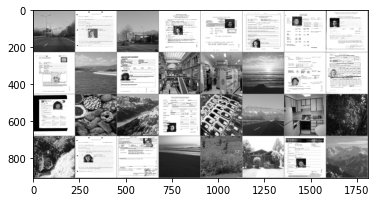

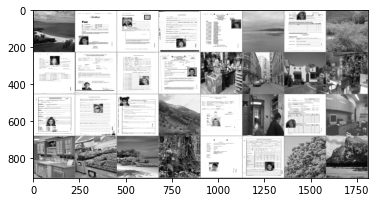

In [ ]:
#showing some of the images
import matplotlib.pyplot as plt
import numpy as np

#functions to show an image


def imshow(img,i):
    img = img / 2 + 0.5     # unnormalize
    # img = img - np.amin(img) # this makes the smallest value 0
    # img = img/np.amax(img) # this makes values go from 0 to 1
    # img = (255*img).astype(np.uint8) # strectch values to 255 and cast to unit8
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.savefig('gdrive/My Drive/VASTECH-SSSD/batch'+str(i)+'.png')

    plt.show()
i=0
for local_batch, local_labels in training_generator:
  i+=1
  imshow(torchvision.utils.make_grid(local_batch),i)
  if i==2:

    break;


In [ ]:
#defining our convolutional network
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 32, 5)
        self.fc1 = nn.Linear(32 * 53 * 53,120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 53 * 53)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
if torch.cuda.is_available():
    net.cuda()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=89888, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)


In [ ]:
#loss function
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
#training
for epoch in range(max_epochs):
    # Training
    running_loss=0.0
    valid_loss=0.0
    i=0
    j=0
    count=0;
    training_total=0
    training_correct=0
    valid_total=0
    valid_correct=0
    print("Training...")
    for local_batch, local_labels in training_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(local_batch)
        loss = criterion(outputs, local_labels)
        loss.backward()
        optimizer.step()
        #count+=1
        #print(count)

        # print statistics
        running_loss += loss.item()
        _, training_predicted = torch.max(outputs.data, 1)

        training_total += local_labels.size(0)
        training_correct += (training_predicted == local_labels).sum().item()
        if i % 32 == 31:
          print('[%d, %3d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 32))
          running_loss = 0.0
        i+=1

    #Validation
    print("Validating...")
    with torch.set_grad_enabled(False):
      for local_batch, local_labels in validation_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        outputs = net(local_batch)
        loss = criterion(outputs, local_labels)
        # print statistics
        valid_loss += loss.item()
        _, valid_predicted = torch.max(outputs.data, 1)

        valid_total += local_labels.size(0)
        valid_correct += (valid_predicted == local_labels).sum().item()
        #print(valid_loss)
        if j %  10== 9:
          print('[%d, %3d] loss: %.3f' %(epoch + 1, j + 1, valid_loss / 10))

          valid_loss = 0.0
        j+=1
    
    print('Accuracy For this training: '+str((100 * training_correct / training_total))+"%")
    print('Accuracy For this validation: '+str((100 * valid_correct / valid_total))+"%")



            

Training...
[1,  32] loss: 0.525
[1,  64] loss: 0.065
[1,  96] loss: 0.031
[1, 128] loss: 0.031
Validating...
[1,  10] loss: 0.024
Accuracy For this training: 93.1566265060241%
Accuracy For this validation: 99.42196531791907%
Training...
[2,  32] loss: 0.019
[2,  64] loss: 0.022
[2,  96] loss: 0.019
[2, 128] loss: 0.014
Validating...
[2,  10] loss: 0.008
Accuracy For this training: 99.32530120481928%
Accuracy For this validation: 99.8073217726397%
Training...
[3,  32] loss: 0.010
[3,  64] loss: 0.017
[3,  96] loss: 0.008
[3, 128] loss: 0.008
Validating...
[3,  10] loss: 0.008
Accuracy For this training: 99.63855421686748%
Accuracy For this validation: 99.8073217726397%
Training...
[4,  32] loss: 0.010
[4,  64] loss: 0.003
[4,  96] loss: 0.008
[4, 128] loss: 0.007
Validating...
[4,  10] loss: 0.003
Accuracy For this training: 99.83132530120481%
Accuracy For this validation: 100.0%
Training...
[5,  32] loss: 0.008
[5,  64] loss: 0.004
[5,  96] loss: 0.007
[5, 128] loss: 0.002
Validating.

In [ ]:
PATH = 'gdrive/My Drive/VASTECH-SSSD/cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for local_batch, local_labels in testing_generator:
        # Transfer to GPU
        local_batch, local_labels = local_batch.to(device), local_labels.to(device)
        outputs = net(local_batch)
        _, predicted = torch.max(outputs.data, 1)

        total += local_labels.size(0)
        correct += (predicted == local_labels).sum().item()

print('Accuracy of the network on test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on test images: 100 %
